Fisher Analysis End!
The expected result is : [0, 2]
The predicted result is : [0 2]


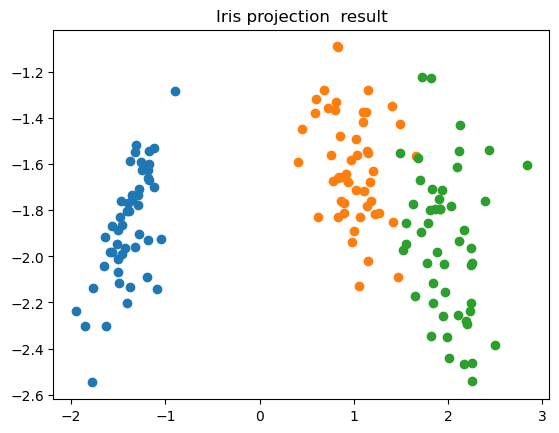

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import heapq #topk

from sklearn.datasets import load_iris

# LDA线性回归分析
class Fisher_Analysis:
    def __init__(self, classification=3, tar_dim=1):

        self.S = None  # 类内协方差矩阵，等于每一个类别的协方差矩阵的求和
        self.B = None  # 类间协方差矩阵
        self.classification = classification  # 总类别
        self.tar_dim = tar_dim  # 降维后的度数

        self.train_data = None  # 训练数据 type:list 后面用于画图

        assert (self.tar_dim <= classification - 1)  # 最多只能降维到类别数-1

        self.w = []  # 存放特征向量
        self.means = []  # 每一个类别的均值

    def fit(self, train_data, train_label):
        '''
            train_data(type:list)[array,array,array,......]
            train_label(type:list)[array,array,array,......]
        '''

        self.train_data = train_data

        # 求出S，每一个类别的协方差矩阵相加
        for data in train_data:
            if self.S is None:
                self.S = np.cov(data, rowvar=False)  # 开始的时候是None，直接赋值
            else:
                self.S += np.cov(data, rowvar=False)  # 后面叠加

        # 求出每一个类别的均值，
        for data in train_data:
            self.means.append(np.mean(data, axis=0))  # 在样本的维度上进行叠加

        # 求出所有样本的均值
        total_train_data = np.concatenate(train_data, axis=0)
        total_mean = np.mean(total_train_data.reshape(-1, total_train_data.shape[-1]), axis=0)  # 所有的样本全部打包成一个数据集，(B,)
        total_mean = total_mean.reshape(-1, 1)  # 矩阵的形状变为 [B,]--->[B,1],便于后面矩阵乘法

        # 计算B，计算每一个类别u_i和整体数据u的协方差矩阵，然后再按照每一个类别的数量加权求和
        for index in range(len(self.means)):

            self.means[index] = self.means[index].reshape(-1, 1)  # 矩阵的形状变为 [B,]--->[B,1],便于后面矩阵乘法
            cov_matrix = np.matmul(self.means[index] - total_mean,
                                   (self.means[index] - total_mean).T)  # 计算每一个类别u_i和整体数据u的协方差矩阵

            # 加权求和
            if self.B is None:
                self.B = train_data[index].shape[0] * cov_matrix
            else:
                self.B += train_data[index].shape[0] * cov_matrix

        # 求出我们要进行特征向量分解的矩阵
        self.tar_matrix = np.matmul(np.linalg.inv(self.S), self.B)

        # 求特征值和特征向量
        eigenvalue, eigenvector = np.linalg.eig(self.tar_matrix)
        eigenvalue = list(eigenvalue)
        eigenvector = eigenvector.T

        # 取出前tar_dim个特征值对应的特征向量
        topk_eigen = heapq.nlargest(self.tar_dim, range(len(eigenvalue)), eigenvalue.__getitem__)

        #根据前k个特征值选取前k个特征向量
        for index in topk_eigen:
            self.w.append(eigenvector[index].reshape(-1, 1))
        print("Fisher Analysis End!")

    # 目前只写了降为二维的代码 （降维演示）
    def proj_draw(self):
        
        proj_tar=[]
        # 画出每一个类别的分布
        for index in range(len(self.train_data)): #遍历每一个类别
            temp=[]
            for _w in self.w: #对于每一个类别，在不同的基坐标_w下进行投影
                temp.append(np.matmul(self.train_data[index], _w))
                
            temp=np.array(temp) #list转化为np.array
            
            #形状变化 [投影后的维度，这个类的batchsize，1]--->[1，这个类的batchsize，投影后的维度]
            temp=temp.transpose(2,1,0) 
            
            #形状变化 [1，这个类的batchsize，投影后的维度]--->[这个类的batchsize，投影后的维度]
            temp=temp.reshape(temp.shape[1],temp.shape[2])
            proj_tar.append(temp)
        
        #proj_tar的形状：[类别数，这个类的batchsize，投影后的维度]
        proj_tar = np.array(proj_tar)
        
        plt.title("Iris projection  result")
        #画出散点图
        for  index in range(proj_tar.shape[0]):
            plt.scatter(proj_tar[index][:, 0].reshape(-1),proj_tar[index][:, 1].reshape(-1))

    # 对于新输入的数据进行预测
    def predict(self, data):
        '''
        data--- shape：[Batch,Hidden_Dim] （Hidden_Dim就是你原来数据的特征维度）
                type： ndarray
        '''

        # 求出每一个类别的均值向量投影后的向量
        proj_means = []
        for mean in self.means:
            temp_dimension = []
            for _w in self.w:
                # 内积就是投影的过程
                temp_dimension.append(np.dot(_w.T, mean).item())
            proj_means.append(temp_dimension)

        # proj_means numpy的形状是 [类别数，] 记录原来每一个均值向量投影后的新向量
        proj_means = np.array(proj_means)

        # 预测数据进行投影降维
        proj_tar = []
        for _w in self.w:
            proj_tar.append(np.matmul(data, _w))

        # 这里transpose是将batchsize放到第一维，便于后面求mse
        # 形状的变化为：[新维度,batchsize,1]---> [batchsize,新维度，1]
        proj_tar = np.transpose(np.array(proj_tar), (1, 0, 2))

        # 形状的变化为：[batchsize,新维度，1]---> [batchsize,新维度]
        proj_tar = proj_tar.reshape(proj_tar.shape[0], proj_tar.shape[1])

        # 计算MSE，判别类别
        Mse_dis = []
        for proj_data in proj_tar:  # 遍历每一个样本
            dis = []
            for proj_mean in proj_means:  # 遍历每一个类别均值
                dis.append(np.mean((proj_mean - proj_data) ** 2))  # 求MSE
            Mse_dis.append(dis)

        Mse_dis = np.array(Mse_dis)  # Mse_dis形状为[batchsize,类别数]，里面存放mse距离

        classification = np.argmin(Mse_dis, axis=1)  # 求出最小的距离下标，就是最终预测类别

        return classification


if __name__ == '__main__':
    # 准备数据
    iris=load_iris()
    X=iris.data
    y=iris.target    

    # 进行降维/训练
    fisher = Fisher_Analysis(4, 2)
    
    train_data=[X[:50,:],X[50:100,:],X[100:,:]]
    train_label=[[y[:50],y[50:100],y[100:]]]
    fisher.fit(train_data, train_label)
    fisher.proj_draw()
    
    test_data=[[5.1,3.5,1.4,0.2],[5.9,3.,5.1,1.8]]
    test_data=np.array(test_data)
    result=fisher.predict(test_data)
    print("The expected result is :",[0,2])
    print("The predicted result is :",result)

